# 0. Setup Paths


In [6]:
import os


In [7]:
CUSTOM_MODEL_NAME = 'james_ssd_mobnet'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'



In [8]:
paths = {
    'WORKSPACE_PATH': os.path.join('workspace'),
    'SCRIPTS_PATH': os.path.join('scripts'),
    'APIMODEL_PATH': os.path.join('models'),
    'PROTOC_PATH':os.path.join('protoc'),
    'ANNOTATION_PATH': os.path.join('workspace','annotations'),
    'IMAGE_PATH': os.path.join('workspace','images'), # contain colected imgs
    'MODEL_PATH': os.path.join('workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('workspace','models',CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': os.path.join('workspace','models',CUSTOM_MODEL_NAME, 'export'),
    'TFJS_PATH':os.path.join('workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'),
    'TFLITE_PATH':os.path.join('workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'),
 }

In [9]:
files = {
    'PIPELINE_CONFIG':os.path.join('workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p "{path}"
        if os.name == 'nt':
            !mkdir "{path}"

# 1. Download TF Pretrained Model from Tensorflow Model Zoo and Install TFOD

In [6]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
  !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [7]:
# Install Tensorflow Object Detection
if os.name=='posix':
    # !apt-get install protobuf-compiler
    !cd models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip 
    !cd models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd models/research/slim && pip install -e . 

Processing /home/james/Desktop/summer/tfod/models/research
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached avro_python3-1.10.2-py3-none-any.whl
  Using cached apache_beam-2.52.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.3 kB)
  Using cached Pillow-10.1.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (9.5 kB)
  Using cached lxml-4.9.3-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.8 kB)
  Using cached matplotlib-3.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached Cython-3.0.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.2 kB)
  Using cached contextlib2-21.6.0-py2.py3-none-any.whl (13 kB)
  Using cached tf_slim-1.1.0-py2.py3-none-any.whl (352 kB)
  Using cached pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.1 kB)
  Using cached lvis-0.5.3-py3-

In [8]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

2023-12-10 16:41:32.168176: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 16:41:32.230964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 16:41:32.231009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 16:41:32.232906: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 16:41:32.242440: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 16:41:32.242684: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [9]:
import object_detection
import PIL
import yaml

In [10]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv "{PRETRAINED_MODEL_NAME+'.tar.gz'}" "{paths['PRETRAINED_MODEL_PATH']}"
    !cd "{paths['PRETRAINED_MODEL_PATH']}" && tar -zxvf "{PRETRAINED_MODEL_NAME+'.tar.gz'}"
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2023-12-10 16:42:36--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 

172.217.167.91, 172.217.167.123, 142.250.66.219, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.167.91|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  3.56MB/s    in 5.2s    

2023-12-10 16:42:42 (3.77 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/sa

#2. Create Label Map

In [11]:
labels = [{'name':'ThumbsUp', 'id':1}, {'name':'ThumbsDown', 'id':2}, {'name':'ThankYou', 'id':3}, {'name':'LiveLong', 'id':4}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TFRecords
TFRecords are a binary file format for storing data.  Using a  TFRecord helps speed up training for your custom object

In [12]:
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf "{ARCHIVE_FILES}"

In [13]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord "{paths['SCRIPTS_PATH']}"

In [14]:
!python "{files['TF_RECORD_SCRIPT']}" -x "{os.path.join(paths['IMAGE_PATH'], 'train')}" -l "{files['LABELMAP']}" -o "{os.path.join(paths['ANNOTATION_PATH'], 'train.record')}"
!python "{files['TF_RECORD_SCRIPT']}" -x "{os.path.join(paths['IMAGE_PATH'], 'test')}" -l "{files['LABELMAP']}" -o "{os.path.join(paths['ANNOTATION_PATH'], 'test.record')}"

2023-12-10 16:42:52.883653: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 16:42:52.883695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 16:42:52.885419: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Successfully created the TFRecord file: workspace/annotations/train.record
2023-12-10 16:42:57.136886: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 16:42:57.136927: E external/local_xla/xla/stream_executor/cuda/cuda_

# 4. Copy Model Config to Training Folder

In [15]:
if os.name  == 'posix':
  !cp "{os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')}" "{os.path.join(paths['CHECKPOINT_PATH'])}"



In [16]:
%pip install protobuf==3.20.0

  Using cached protobuf-3.20.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.52.0 requires protobuf!=4.0.*,!=4.21.*,!=4.22.0,!=4.23.*,!=4.24.*,<4.26.0,>=3.20.3, but you have protobuf 3.20.0 which is incompatible.
google-api-core 2.15.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
googleapis-common-protos 1.62.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
tensorflow 2.15.0.post1 requires protobuf

In [28]:
%pip install tensorflow==2.13.0

  Using cached tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached keras-2.13.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached protobuf-4.25.1-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)
  Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl (18 kB)
Using cached tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (524.1 MB)
Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)
Using cached protobuf-4.25.1-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl (440 kB)
  Attempting unin

In [37]:
%pip install protobuf==3.20.0

  Using cached protobuf-3.20.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.1
    Uninstalling protobuf-4.25.1:
      Successfully uninstalled protobuf-4.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.52.0 requires protobuf!=4.0.*,!=4.21.*,!=4.22.0,!=4.23.*,!=4.24.*,<4.26.0,>=3.20.3, but you have protobuf 3.20.0 which is incompatible.
google-api-core 2.15.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
googleapis-common-protos 1.62.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
tensorflow 2.13.0 requires protobuf!=4.21

# 5. Update Config For Tranfer Learning

In [38]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [39]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
config

{'model': ssd {
   num_classes: 4
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   match

In [40]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], 'r') as f:
  proto_str = f.read()
  text_format.Merge(proto_str, pipeline_config)

In [41]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = 'detection'
pipeline_config.train_input_reader.label_map_path = files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [42]:
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'],'wb') as f:
  f.write(config_text)

# 6. Train the model

In [43]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')


In [44]:
command = f"python {TRAINING_SCRIPT} --model_dir={paths['CHECKPOINT_PATH']} --pipeline_config_path={files['PIPELINE_CONFIG']} --num_train_steps=2000"

In [56]:
!python "models/research/object_detection/model_main_tf2.py" \
  --model_dir="workspace/models/james_ssd_mobnet" \
  --pipeline_config_path="workspace/models/james_ssd_mobnet/pipeline.config" \
  --num_train_steps=2000


2023-12-10 17:06:40.119149: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 17:06:40.180445: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 17:06:40.181151: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 17:06:41.533064: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-10 17:06:44.406606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do

# 7. Evaluate the Model

In [ ]:
eval_command = f"python {TRAINING_SCRIPT} --model_dir={paths['CHECKPOINT_PATH']} --pipeline_config_path={files['PIPELINE_CONFIG']} --checkpoint_dir={paths['CHECKPOINT_PATH']}"
print(eval_command)

python /content/drive/MyDrive/Colab Notebooks/summer/object_detection /tutorial /models/research/object_detection/model_main_tf2.py --model_dir=/content/drive/MyDrive/Colab Notebooks/summer/object_detection /tutorial /workspace/models/james_ssd_mobnet --pipeline_config_path=/content/drive/MyDrive/Colab Notebooks/summer/object_detection /tutorial /workspace/models/james_ssd_mobnet/pipeline.config --checkpoint_dir=/content/drive/MyDrive/Colab Notebooks/summer/object_detection /tutorial /workspace/models/james_ssd_mobnet


In [ ]:
!python "/content/drive/MyDrive/Colab Notebooks/summer/object_detection /tutorial /models/research/object_detection/model_main_tf2.py" \
  --model_dir="/content/drive/MyDrive/Colab Notebooks/summer/object_detection /tutorial /workspace/models/james_ssd_mobnet" \
  --pipeline_config_path="/content/drive/MyDrive/Colab Notebooks/summer/object_detection /tutorial /workspace/models/james_ssd_mobnet/pipeline.config" \
  --checkpoint_dir="/content/drive/MyDrive/Colab Notebooks/summer/object_detection /tutorial /workspace/models/james_ssd_mobnet"

2023-12-07 06:49:46.263903: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
W1207 06:49:51.859286 137542397244032 model_lib_v2.py:1089] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I1207 06:49:51.859655 137542397244032 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1207 06:49:51.859815 137542397244032 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I1207 06:49:51.859961 137542397244032 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W1207 06:49:51.860454 137542397244032 model_lib_v2.py:1106] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2023-12-07 06:49:53.359397: W tensorflow/core/common_runtime/gpu/gpu_bfc_alloca

# 8. Load Train Model From Checkpoint

In [14]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [15]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-6')).expect_partial()

@tf.function
def detect_fn(image):
  image, shapes = detection_model.preprocess(image)
  prediction_dict = detection_model.predict(image, shapes)
  detections = detection_model.postprocess(prediction_dict, shapes)
  return detections

# 9. Detect from an Image

In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [17]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [18]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'thumbsup.be6f87fc-9430-11ee-8817-7cb0c2fc9053.jpg')


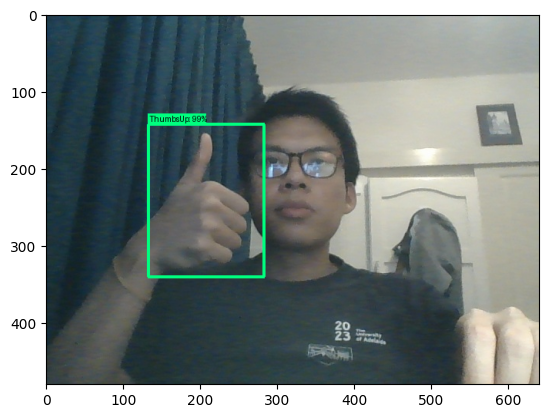

In [19]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
label_id_offset = 1
image_np_with_detections = image_np.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()


# 10. Real Time Detection from Webcam


In [20]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('x'):
        cap.release()
        cv2.destroyAllWindows()
        break

# 10. Export the model


In [21]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [22]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])
print(command)

python models/research/object_detection/exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=workspace/models/james_ssd_mobnet/pipeline.config --trained_checkpoint_dir=workspace/models/james_ssd_mobnet --output_directory=workspace/models/james_ssd_mobnet/export


In [23]:
!{command}

2023-12-10 18:01:10.356117: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 18:01:10.415200: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 18:01:10.415750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 18:01:11.832324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-10 18:01:14.516124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do

# 11. Export tensorflowjs

In [24]:
%pip install tensorflowjs

  Using cached rich-13.7.0-py3-none-any.whl.metadata (18 kB)
  Using cached protobuf-4.25.1-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached tensorboard-2.15.1-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
INFO: pip is looking at multiple versions of tensorstore to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tensorstore to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 2.5 MB/s eta 0:00:00
  Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)
   ━━━━━━━━━━━━

In [25]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])
print(command)

tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default workspace/models/james_ssd_mobnet/export/saved_model workspace/models/james_ssd_mobnet/tfjsexport


In [26]:
!{command}

2023-12-10 18:04:38.357229: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 18:04:38.410721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 18:04:38.410771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 18:04:38.412267: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 18:04:38.422739: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 18:04:38.423105: I tensorflow/core/platform/cpu_feature_guard.cc:1